In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
from DE_library import simulate_ODE, simulate_phase_portrait
import matplotlib.pyplot as plt
from example_utils import reject_outliers, initial_conditions, plot_phase_portrait

from MARBLE import utils, geometry, net, plotting, postprocessing, compare_attractors

In [2]:
def simulate_system(mu, X0):
    p, v = simulate_phase_portrait('vanderpol', t, X0, par = {'mu': mu})
    pos, vel = [], []
    for p_, v_ in zip(p,v):
        ind = reject_outliers(p_, v_)
        pos.append(p_[ind])
        vel.append(v_[ind])
        
    return pos, vel

# Geneate phase portraits from random initial conditions while varying $\beta_1$

In [13]:
t0, t1, dt = 0, 3, 0.5
t = np.arange(t0, t1, dt)
n = 100
area = [[-3,-3],[3,3]]
n_steps=10
beta1 = np.hstack((np.linspace(-.5,.5,n_steps)))

pos, vel = [], []
X0_range = initial_conditions(n, len(beta1), area)
for i, b1 in enumerate(beta1):
    p, v = simulate_system(b1, X0_range[i])
            
    pos.append(np.vstack(p))
    vel.append(np.vstack(v))

/mnt/scratch/lts2/gosztolai/miniconda3/envs/MARBLE/lib/python3.9/site-packages/scipy/integrate/_odepack_py.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


# Display state spaces under four different parameter conditions

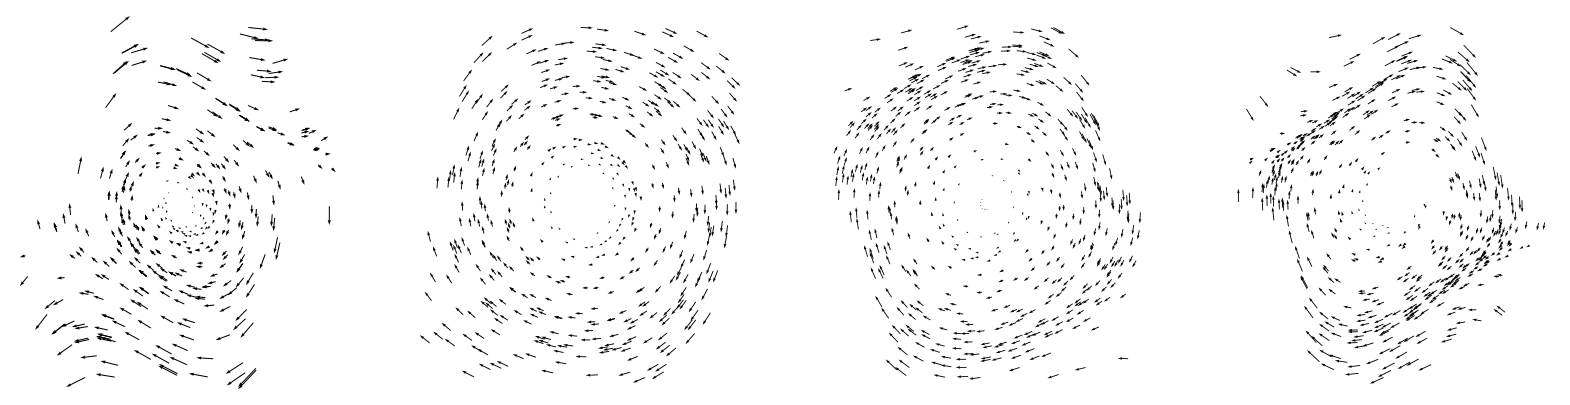

In [4]:
fig, ax = plt.subplots(1,4, figsize=(20,5))
    
plot_phase_portrait(pos[0], vel[0], ax[0])
plot_phase_portrait(pos[n_steps//2-1], vel[n_steps//2-1], ax[1])
plot_phase_portrait(pos[n_steps//2+1], vel[n_steps//2+1], ax[2])
plot_phase_portrait(pos[-1], vel[-1], ax[3])

# Train network

In [5]:
k=10

data = utils.construct_dataset(pos, features=vel, graph_type='cknn', k=k, stop_crit=0.02)

---- Embedding dimension: 2
---- Signal dimension: 2

Embedding dimension <= 2, so manifold computations are disabled!


In [6]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="2"

par = {'batch_size': 64, #batch size
       'epochs': 30, #optimisation epochs
       'order': 2, #order of derivatives
       'n_lin_layers': 2,
       'hidden_channels': 8, #number of internal dimensions in MLP
       'out_channels': 3,
       'inner_product_features': True,
      }

model = net(data, **par)
model.run_training(data)


---- Settings: 

batch_size : 64
epochs : 30
order : 2
n_lin_layers : 2
hidden_channels : 8
out_channels : 3
inner_product_features : True
lr : 0.001
autoencoder : False
diffusion : False
frac_sampled_nb : -1
dropout : 0.0
bias : True
vec_norm : False
batch_norm : None
seed : 0
processes : 1
dim_signal : 2
dim_emb : 2
n_sampled_nb : -1

---- Number of features to pass to the MLP:  7
---- Total number of parameters:  121

---- Training network ... 

Epoch: 1, Training loss: 1.3907, Validation loss: 1.3875
Epoch: 2, Training loss: 1.3842, Validation loss: 1.3817
Epoch: 3, Training loss: 1.3757, Validation loss: 1.3670
Epoch: 4, Training loss: 1.3480, Validation loss: 1.3227
Epoch: 5, Training loss: 1.2788, Validation loss: 1.2339
Epoch: 6, Training loss: 1.2191, Validation loss: 1.2146
Epoch: 7, Training loss: 1.1949, Validation loss: 1.1921
Epoch: 8, Training loss: 1.1909, Validation loss: 1.1172
Epoch: 9, Training loss: 1.2016, Validation loss: 1.1815
Epoch: 10, Training loss: 1.1763,

# Create another dataset from a different sampling

In [7]:
t0, t1, dt = 0, 3, 0.5
t = np.arange(t0, t1, dt)
n = 100
area = [[-3,-3],[3,3]]

n_steps=10
beta1 = np.hstack((np.linspace(-0.5, 0.5, n_steps)))

pos, vel = [], []
X0_range = initial_conditions(n, len(beta1), area)
for i, b1 in enumerate(beta1):
    p, v = simulate_system(b1, X0_range[i])
            
    pos.append(np.vstack(p))
    vel.append(np.vstack(v))
    
data_transfer = utils.construct_dataset(pos, features=vel, graph_type='cknn', k=k, stop_crit=0.0)

/mnt/scratch/lts2/gosztolai/miniconda3/envs/MARBLE/lib/python3.9/site-packages/scipy/integrate/_odepack_py.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


---- Embedding dimension: 2
---- Signal dimension: 2

Embedding dimension <= 2, so manifold computations are disabled!


# Evalute network on both data

In [8]:
data = model.evaluate(data) #original data
data_transfer = model.evaluate(data_transfer) #resampled data

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


Performed umap embedding on embedded results.
Performed MDS embedding on embedded results.
Performed umap embedding on embedded results.
Performed MDS embedding on embedded results.


<AxesSubplot:>

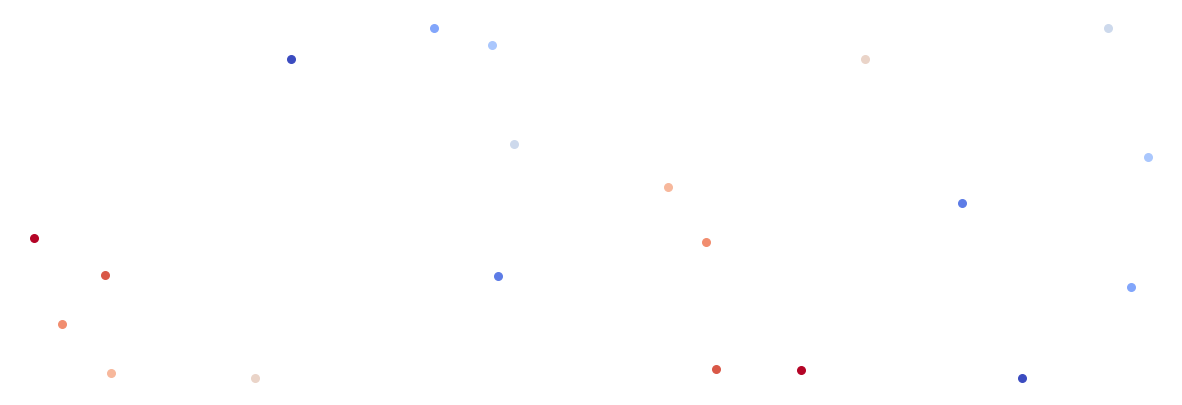

In [9]:
fig, ax = plt.subplots(1,2, figsize=(15,5))

n_clusters=15
data = postprocessing(data, n_clusters=n_clusters)
emb_MDS, _ = geometry.embed(data.dist, embed_typ = 'MDS')
plotting.embedding(emb_MDS, beta1, ax=ax[0], s=30, alpha=1)

data_transfer = postprocessing(data_transfer, n_clusters=n_clusters)
emb_MDS_transfer, _ = geometry.embed(data_transfer.dist, embed_typ = 'MDS')
plotting.embedding(emb_MDS_transfer, beta1, ax=ax[1], s=30, alpha=1)

# Compare distance matrices

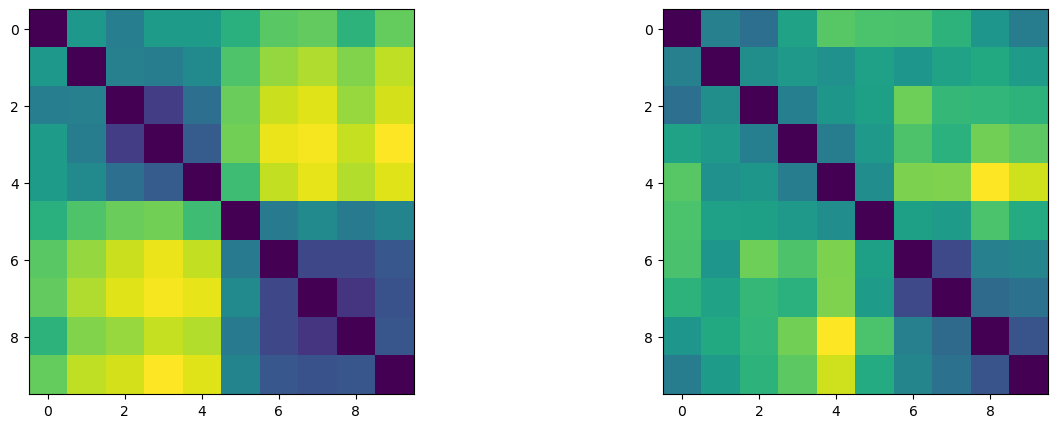

In [10]:
fig, ax = plt.subplots(1,2, figsize=(15,5))
ax[0].imshow(data.dist)
ax[1].imshow(data_transfer.dist)

# Compare embeddings

<AxesSubplot:>

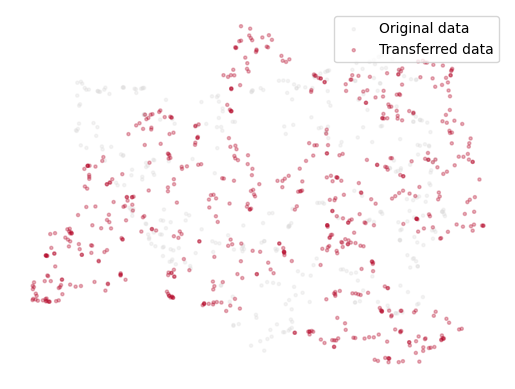

In [11]:
titles = ['Original data', 'Transferred data']
plotting.embedding(np.vstack([data.emb_2d, data_transfer.emb_2d]), 
                   np.hstack([np.zeros(len(data.emb_2d)),np.ones(len(data_transfer.emb_2d))]), 
                   titles=titles)

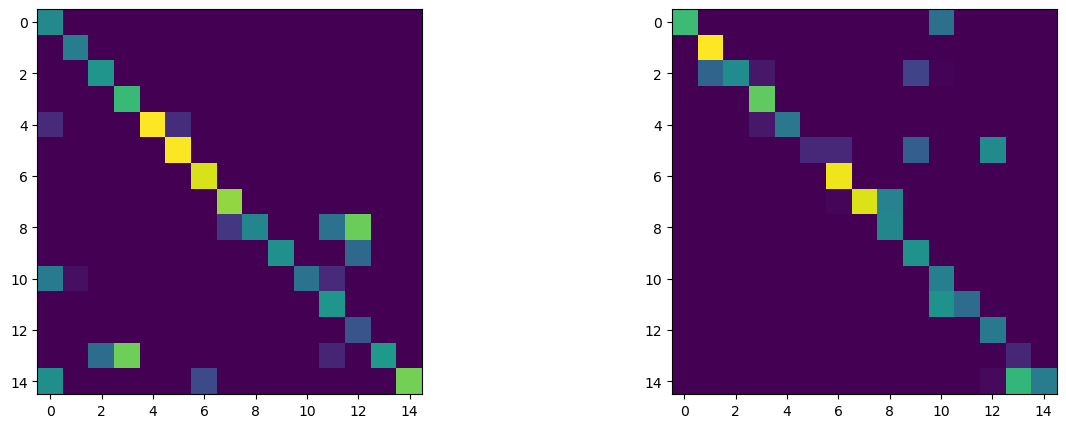

In [12]:
fig, ax = plt.subplots(1,2, figsize=(15,5))

ax[0].imshow(data.gamma[3,5])
ax[1].imshow(data_transfer.gamma[3,5])